In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

**Trabajo Práctico n°1**

- Generar un grafo a partir de la versión .csv del elliptic dataset. 

- Graficar, visualizar, y comparar con el grafo que viene por defecto en la librería torch-geometric. 

- Analizar las variables asociadas a cada id involucrado en las transacciones.

# Construcción del grafo a partir de Elliptic Graph Dataset y análisis exploratorio 

El dataset que usaremos es una variante del Elliptic Data Set, presentado por Weber et al. en 2019 [1] con datos provistos por Elliptic [2]. 

Se trata de un dataset con datos de más de 234 mil transacciones de Bitcoin entre más de 200 mil nodos. 

Una proporción de esas transacciones fueron etiquetadas como fraudulentas o no fraudulentas, mientras que de la mayoría se desconoce su etiqueta. 

También se incluyen 165 features anonimizadas de cada transacción. 

In [2]:
# 1. Cargar el CSV
df = pd.read_csv("../data/elliptic_graph_dataset.csv")

## Análisis preliminar del dataset

In [3]:
df.columns

Index(['person_id_from', 'person_id_to', 'fraud_label', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6',
       ...
       'feature_155', 'feature_156', 'feature_157', 'feature_158',
       'feature_159', 'feature_160', 'feature_161', 'feature_162',
       'feature_163', 'feature_164'],
      dtype='object', length=168)

In [4]:
df.head()

,person_id_from,person_id_to,fraud_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164
0,0,1,2,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,2,3,2,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,4,5,2,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579381,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
3,6,7,2,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,8,9,2,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.128722,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521400


## Filas de dataset

- cada fila es una transacción entre person_id_from y person_id_to

## Columnas del dataset

- person_id_from: quien envia

- person_id_to: quien recibe 

- fraud_label: etiqueta de fraude (1 = fraudulento, 0 = no fraudulento, 2 = deconocida)

- feature_0 a feature_164: características de la transacción

### Valores nulos

In [5]:
# Chequear si hay al menos un valor null en el df
df.isnull().values.any()

np.False_

No se encuentran valores nulos.

## Construcción del grafo a partir del csv pre-procesado

Se trata de un grafo dirigido ya que los nexos entre los nodos no son recíprocos sino que tienen un origen y un destino. 

Las `features` se aplican al nodo de origen. 

La `fraud_label` se aplica al nexo entre los nodos. 

### Visualización del grafo

Como el grafo es muy grande, es complicado visualizar en su totalidad.
Es por ello que se toman 5000 nodos al azar, y se colorea cada uno según el label asignado, siendo:
* 0 = Fraudulenta (rojo)
* 1 = NO fraudulenta (verde)
* 2 = Desconocido (gris)

In [6]:
# 2. Crear el grafo dirigido (el flujo tiene dirección)
G = nx.DiGraph()

In [7]:
# 3. Agregar nodos y aristas
for _, row in df.iterrows():
    src = row['person_id_from']
    dst = row['person_id_to']
    fraud_label = row['fraud_label']
    
    # Agregar src con features y fraud_label si no existe
    if src not in G:
        features_src = row[[f'feature_{i}' for i in range(165)]].tolist()
        G.add_node(src, features=features_src, fraud_label=fraud_label)
    else:
        # Si ya existe, actualizamos el fraud_label si el actual es desconocido (2)
        if G.nodes[src].get('fraud_label', 2) == 2:
            G.nodes[src]['fraud_label'] = fraud_label
    
    # Agregar dst
    if dst not in G:
        G.add_node(dst, features=[None]*165, fraud_label=2)  # 2 = desconocido por default

    # Agregar arista (sin label porque ya no lo usamos en arista)
    G.add_edge(src, dst)

# Verificamos cantidad de nodos y aristas
print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")



Nodos: 203769, Aristas: 234355


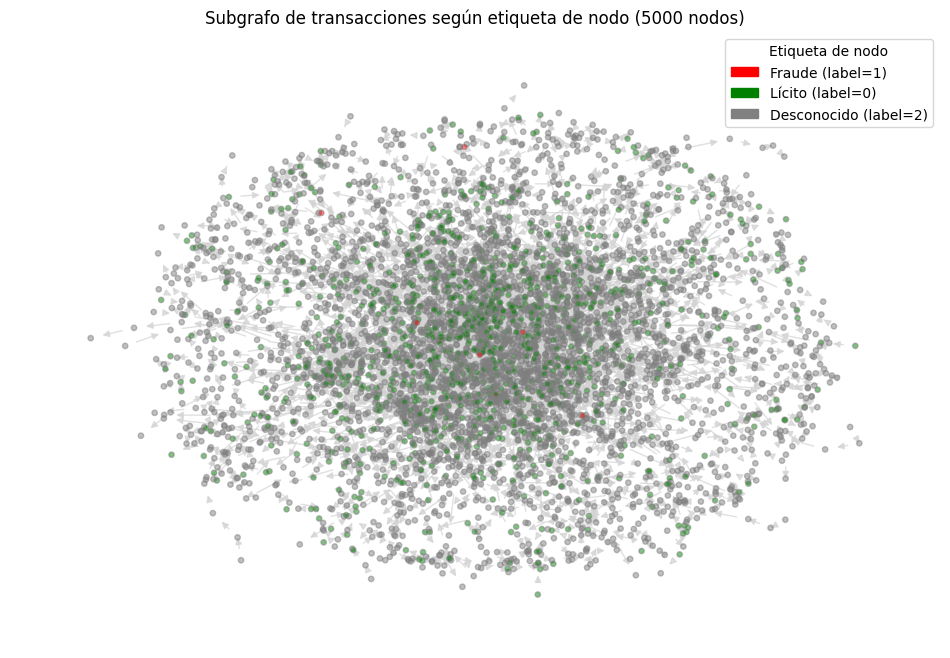

In [8]:
# 4. Visualizar una parte del grafo
subgraph = G.subgraph(list(G.nodes)[:5000])
pos = nx.fruchterman_reingold_layout(subgraph, seed=42)
plt.figure(figsize=(12, 8))

# Colores según el fraud_label del nodo
color_map = []
for n, d in subgraph.nodes(data=True):
    label = d.get('fraud_label', 2)
    if label == 1:
        color_map.append('red')
    elif label == 0:
        color_map.append('green')
    else:
        color_map.append('gray')

# Dibujar nodos
nx.draw_networkx_nodes(subgraph, pos, node_size=15, node_color=color_map, edgecolors="tab:gray", alpha=0.5)

# Dibujar aristas
nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.7, edge_color='lightgray')

plt.title("Subgrafo de transacciones según etiqueta de nodo (5000 nodos)")
plt.axis('off')

import matplotlib.patches as mpatches
# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Fraude (label=1)'),
    mpatches.Patch(color='green', label='Lícito (label=0)'),
    mpatches.Patch(color='gray', label='Desconocido (label=2)')
]
plt.legend(handles=legend_elements, loc='upper right', title="Etiqueta de nodo")

## Análisis exploratorio del grafo

### In-degrees y out-degrees

In [9]:
# Extraer grados
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Convertir a DataFrame para análisis
degree_df = pd.DataFrame({
    'node': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()]
})

In [10]:
# Estadísticas básicas
desc_stats = degree_df[['in_degree', 'out_degree']].describe()
print(desc_stats)


           in_degree     out_degree
count  203769.000000  203769.000000
mean        1.150101       1.150101
std         3.911132       1.894740
min         0.000000       0.000000
25%         0.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       284.000000     472.000000


#### Nodos con mayor in-degree y out-degree

In [11]:
print("Nodos con mayor in-degree:")
print(degree_df.sort_values('in_degree', ascending=False).head())

print("\nNodos con mayor out-degree:")
print(degree_df.sort_values('out_degree', ascending=False).head())


Nodos con mayor in-degree:
            node  in_degree  out_degree
51483    51371.0        284           0
51377    51437.0        247           0
148195  148292.0        241           0
35892    35892.0        239           0
24761    24761.0        212           0

Nodos con mayor out-degree:
            node  in_degree  out_degree
94301    94301.0          1         472
130        130.0          1         288
141818  141786.0          0         122
133793  133793.0          1         112
198381  198381.0          1          99


Se observa que la mayoría de los nodos (al menos el 75%) tiene sólo un nexo, pero algunos pocos nodos tienen decenas o cientos, con un máximo de 284 nexos entrantes y 472 nexos salientes. 

### Tipos de conexiones

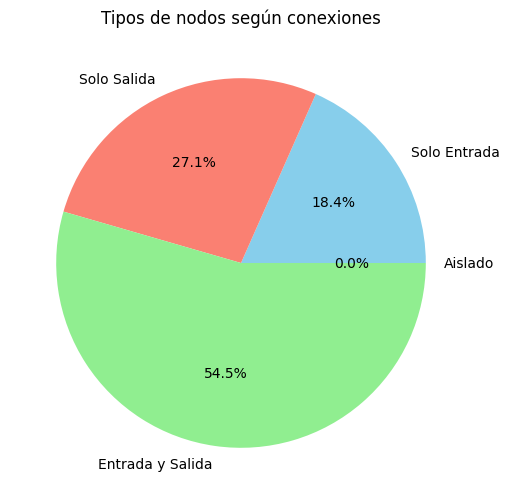

In [12]:
only_in = 0
only_out = 0
both = 0
isolated = 0

for n in G.nodes():
    in_d = G.in_degree(n)
    out_d = G.out_degree(n)
    
    if in_d > 0 and out_d == 0:
        only_in += 1
    elif in_d == 0 and out_d > 0:
        only_out += 1
    elif in_d > 0 and out_d > 0:
        both += 1
    else:
        isolated += 1

# Pie chart
labels = ['Solo Entrada', 'Solo Salida', 'Entrada y Salida', 'Aislado']
sizes = [only_in, only_out, both, isolated]
colors = ['skyblue', 'salmon', 'lightgreen', 'gray']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Tipos de nodos según conexiones")
plt.show()


### Etiquetas de transacciones

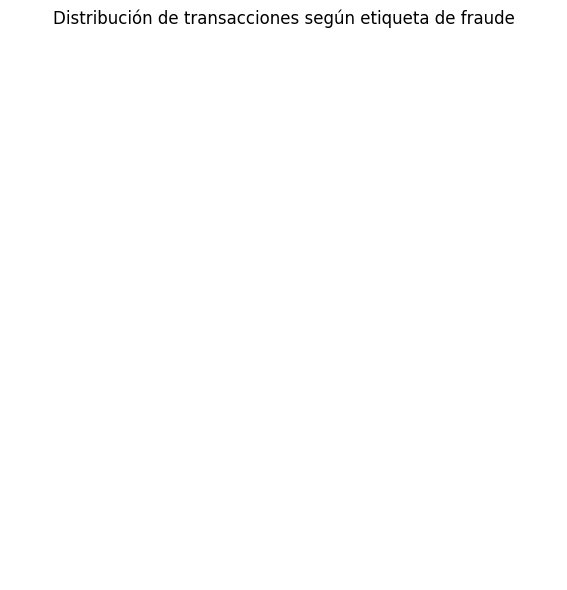

In [ ]:
# Obtener etiquetas de los nodos (transacciones)
labels = nx.get_node_attributes(G, 'fraud_label')

# Contar ocurrencias
fraud_counts = pd.Series(labels.values()).value_counts().sort_index()

# Renombrar etiquetas para el gráfico
fraud_counts.index = fraud_counts.index.map({2: 'Desconocido', 1: 'Fraude', 0: 'No fraude'})

# Donut chart
colors = ['green', 'red', 'gray']  # No fraude, fraude, desconocido

plt.figure(figsize=(6, 6))
plt.pie(
    fraud_counts,
    labels=fraud_counts.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Círculo central para el efecto "donut"
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Distribución de transacciones según etiqueta de fraude (nodos)")
plt.tight_layout()
plt.show()


## Comparación con grafo de torch-geom

### Construcción de grafo a partir de dataset de torch-geom

In [14]:
# Cargar los archivos
features = pd.read_csv("../data/kaggle/elliptic_txs_features.csv", header=None)
edges = pd.read_csv("../data/kaggle/elliptic_txs_edgelist.csv")
classes = pd.read_csv("../data/kaggle/elliptic_txs_classes.csv")

# Renombrar columnas para claridad
features = features.rename(columns={0: "txId", 1: "time_step"})
edges = edges.rename(columns={"txId1": "source", "txId2": "target"})
classes = classes.rename(columns={"txId": "txId", "class": "label"})

# Crear el grafo dirigido
G_crudo = nx.DiGraph()

# Agregar nodos con features
for _, row in features.iterrows():
    tx_id = row["txId"]
    feats = row[2:].values  # features van desde la columna 2 en adelante
    G_crudo.add_node(tx_id, features=feats)

# Agregar aristas
for _, row in edges.iterrows():
    G_crudo.add_edge(row["source"], row["target"])

# Agregar etiquetas de clase a los nodos
label_dict = dict(zip(classes["txId"], classes["label"]))
nx.set_node_attributes(G_crudo, label_dict, "label")

print(f"Nodos: {G_crudo.number_of_nodes()}, Aristas: {G_crudo.number_of_edges()}")

Nodos: 203769, Aristas: 234355


/home/lunix/Documents/DiploDatos/Mentoria/elliptic-gnn-fraud-detector/env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/lunix/Documents/DiploDatos/Mentoria/elliptic-gnn-fraud-detector/env/lib/python3.12/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/lunix/Documents/DiploDatos/Mentoria/elliptic-gnn-fraud-detector/env/lib/python3.12/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/lunix/Documents/DiploDatos/Mentoria/elliptic-gnn-fraud-detector/env/lib/python3.12/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/lunix/Docume

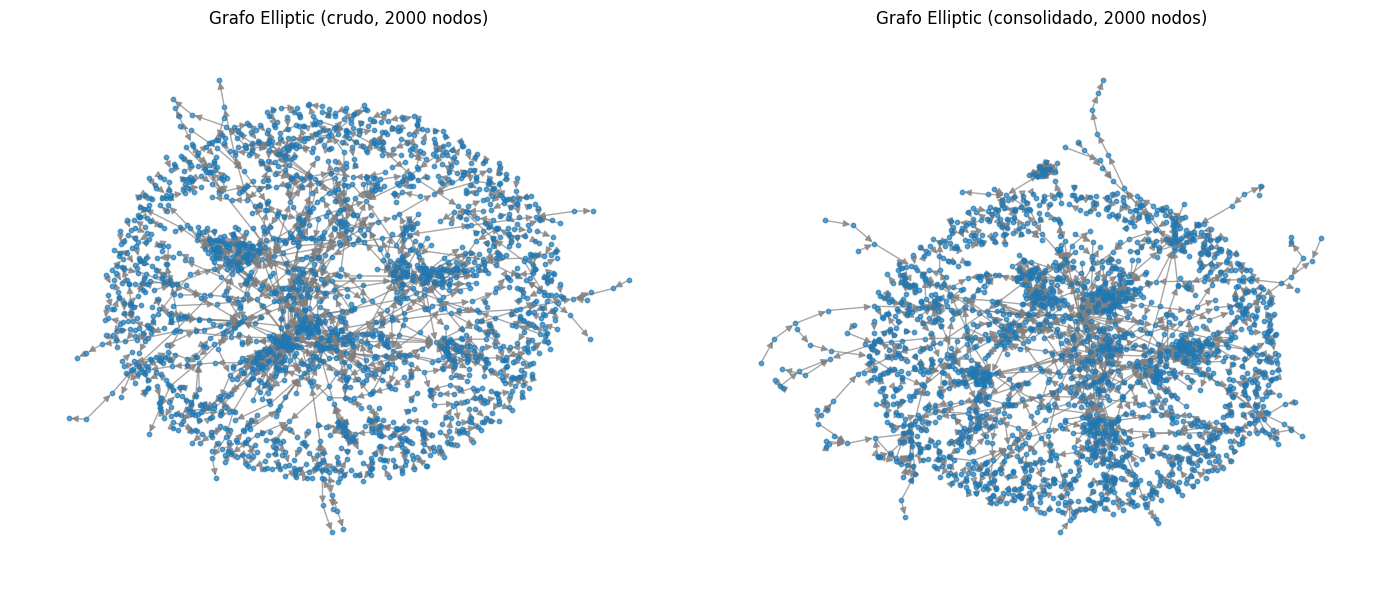

Comparación de nodos y aristas:
- Grafo crudo:         Nodos = 203769, Aristas = 234355
- Grafo consolidado:   Nodos = 203769, Aristas = 234355



In [15]:
import random

# from torch_geometric.datasets import 
from torch_geometric.utils import to_networkx

# Visualización de subgrafos
plt.figure(figsize=(14, 6))

# Subgrafo del grafo crudo
plt.subplot(1, 2, 1)
# Siguientes 2 lineas son para seleccionar 500 nodos aleatorios del grafo crudo
#selected_nodes_crudo = random.sample(list(G_crudo.nodes), 500)
#sub_crudo = G_crudo.subgraph(selected_nodes_crudo)

sub_crudo = G_crudo.subgraph(list(G_crudo.nodes)[:2000]) #selecciona los primeros 2000 nodos
pos_crudo = nx.spring_layout(sub_crudo, seed=42)
nx.draw(sub_crudo, pos_crudo, node_size=10, edge_color='gray', alpha=0.7)
plt.title("Grafo Elliptic (crudo, 2000 nodos)")

# Subgrafo del grafo consolidado
G_consolidado = G
plt.subplot(1, 2, 2)
# Siguientes 2 lineas son para seleccionar 500 nodos aleatorios del grafo consolidado
#selected_nodes_consolidado = random.sample(list(G_consolidado.nodes), 500)
#sub_consolidado = G_consolidado.subgraph(selected_nodes_consolidado)



sub_consolidado = G_consolidado.subgraph(list(G_consolidado.nodes)[:2000]) #Selecciona los primeros 2000 nodos
pos_consolidado = nx.spring_layout(sub_consolidado, seed=42)
nx.draw(sub_consolidado, pos_consolidado, node_size=10, edge_color='gray', alpha=0.7)
plt.title("Grafo Elliptic (consolidado, 2000 nodos)")

plt.tight_layout()
plt.show()

# Estadísticas básicas
print("""Comparación de nodos y aristas:
- Grafo crudo:         Nodos = {}, Aristas = {}
- Grafo consolidado:   Nodos = {}, Aristas = {}
""".format(G_crudo.number_of_nodes(), G_crudo.number_of_edges(), G_consolidado.number_of_nodes(), G_consolidado.number_of_edges()))

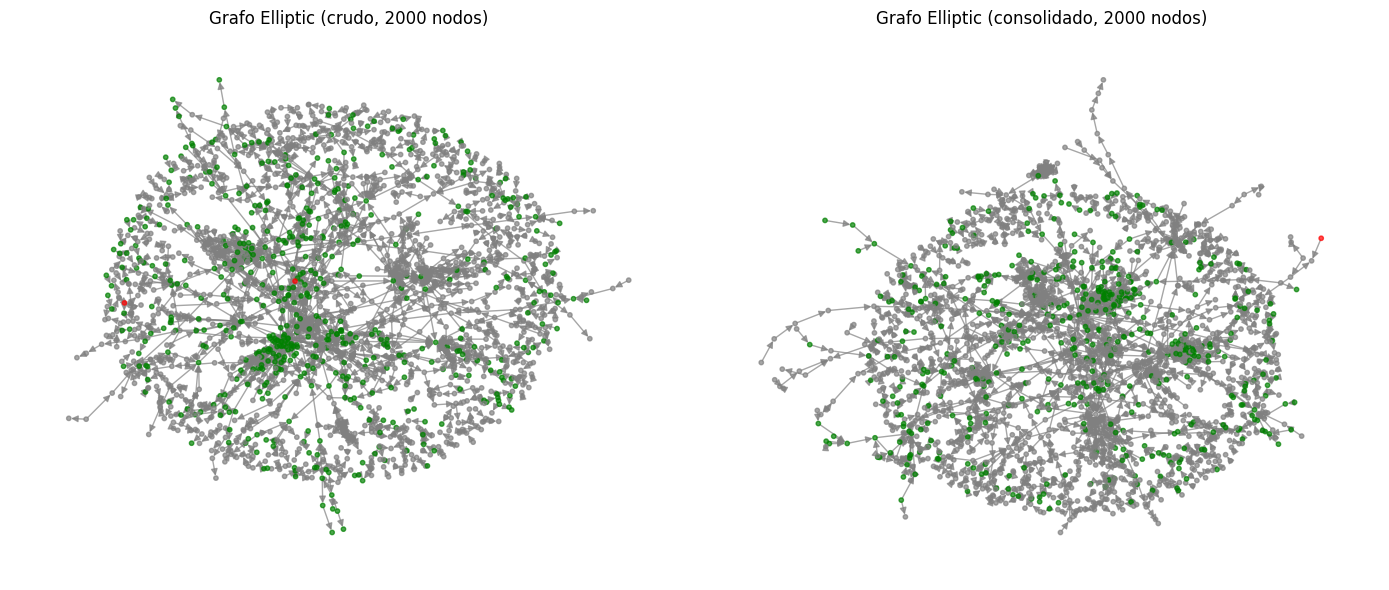

Comparación de nodos y aristas:
- Grafo crudo:         Nodos = 203769, Aristas = 234355
- Grafo consolidado:   Nodos = 203769, Aristas = 234355



In [16]:

plt.figure(figsize=(14, 6))

# --- Grafo crudo ---
plt.subplot(1, 2, 1)
sub_crudo = G_crudo.subgraph(list(G_crudo.nodes)[:2000])
pos_crudo = nx.spring_layout(sub_crudo, seed=42)

# Definir colores según el label
color_map_crudo = []
for node in sub_crudo.nodes(data=True):
    label = str(node[1].get('label', 'unknown'))  # Convertimos a string
    if label == '1':
        color_map_crudo.append('red')
    elif label == '2':
        color_map_crudo.append('green')
    else:
        color_map_crudo.append('gray')

nx.draw(sub_crudo, pos_crudo, node_size=10, node_color=color_map_crudo, edge_color='gray', alpha=0.7)
plt.title("Grafo Elliptic (crudo, 2000 nodos)")

# --- Grafo consolidado ---
plt.subplot(1, 2, 2)
sub_consolidado = G_consolidado.subgraph(list(G_consolidado.nodes)[:2000])
pos_consolidado = nx.spring_layout(sub_consolidado, seed=42)

# Definir colores según el fraud_label
# Definir colores según el fraud_label
color_map_consol = []
for node in sub_consolidado.nodes(data=True):
    label = node[1].get('fraud_label', 2)  # default desconocido si no hay fraud_label
    if label == 1:
        color_map_consol.append('red')
    elif label == 0:
        color_map_consol.append('green')
    else:
        color_map_consol.append('gray')

nx.draw(sub_consolidado, pos_consolidado, node_size=10, node_color=color_map_consol, edge_color='gray', alpha=0.7)
plt.title("Grafo Elliptic (consolidado, 2000 nodos)")

plt.tight_layout()
plt.show()

# Estadísticas básicas
print("""Comparación de nodos y aristas:
- Grafo crudo:         Nodos = {}, Aristas = {}
- Grafo consolidado:   Nodos = {}, Aristas = {}
""".format(G_crudo.number_of_nodes(), G_crudo.number_of_edges(), G_consolidado.number_of_nodes(), G_consolidado.number_of_edges()))


**Graficar y comparar subgrafos al azar, entre 500 y 3000 nodos**

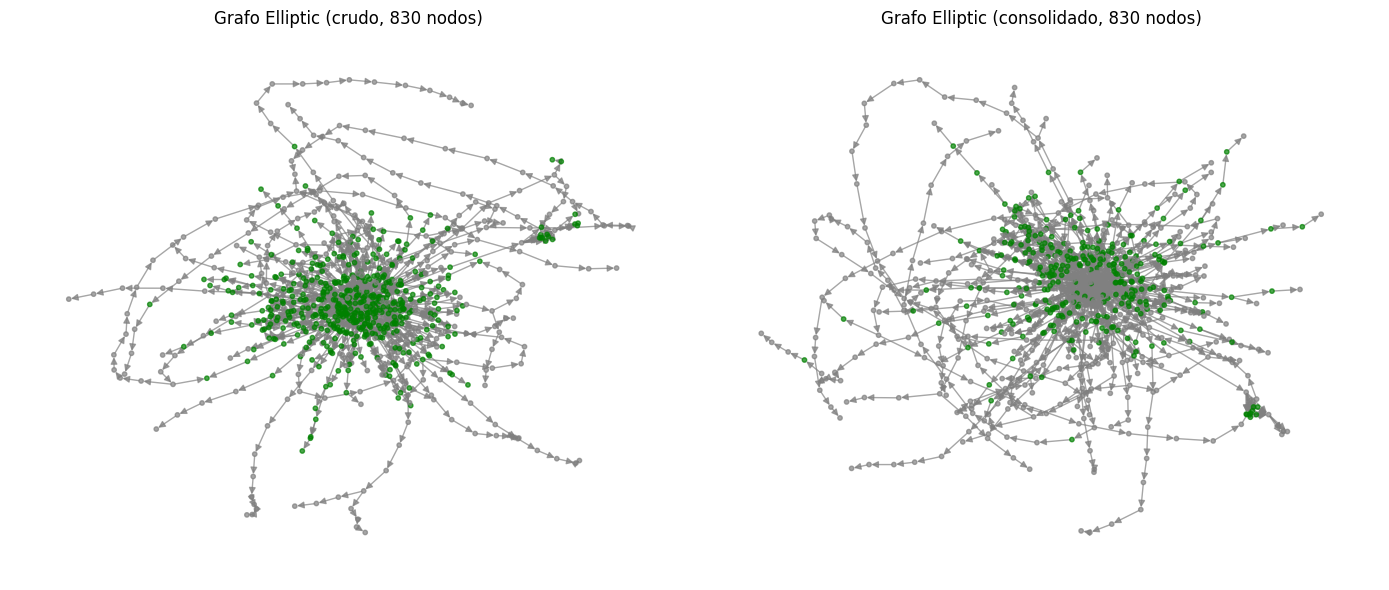

In [17]:
def sample_connected_subgraph(G, label_attr, valid_labels, min_nodes=500, max_nodes=3000):
    for n, d in G.nodes(data=True):
        if d.get(label_attr) in valid_labels:
            # Hacer BFS desde este nodo
            bfs_nodes = list(nx.bfs_tree(G, source=n).nodes)
            if len(bfs_nodes) >= min_nodes:
                selected_nodes = bfs_nodes[:max_nodes]
                return G.subgraph(selected_nodes)
    raise ValueError("No se encontró un componente conectado con al menos el tamaño mínimo solicitado.")

plt.figure(figsize=(14, 6))

# --- Grafo crudo ---
sub_crudo = sample_connected_subgraph(G_crudo, label_attr='label', valid_labels=['1', '2'], min_nodes=500, max_nodes=3000)
pos_crudo = nx.spring_layout(sub_crudo, seed=42)

color_map_crudo = []
for _, d in sub_crudo.nodes(data=True):
    label = str(d.get('label', 'unknown'))
    if label == '1':
        color_map_crudo.append('red')
    elif label == '2':
        color_map_crudo.append('green')
    else:
        color_map_crudo.append('gray')

plt.subplot(1, 2, 1)
nx.draw(sub_crudo, pos_crudo, node_size=10, node_color=color_map_crudo, edge_color='gray', alpha=0.7)
plt.title(f"Grafo Elliptic (crudo, {len(sub_crudo.nodes)} nodos)")

# --- Grafo consolidado ---
sub_consol = sample_connected_subgraph(G_consolidado, label_attr='fraud_label', valid_labels=[0, 1], min_nodes=500, max_nodes=3000)
pos_consol = nx.spring_layout(sub_consol, seed=42)

color_map_consol = []
for _, d in sub_consol.nodes(data=True):
    label = d.get('fraud_label', 2)
    if label == 1:
        color_map_consol.append('red')
    elif label == 0:
        color_map_consol.append('green')
    else:
        color_map_consol.append('gray')

plt.subplot(1, 2, 2)
nx.draw(sub_consol, pos_consol, node_size=10, node_color=color_map_consol, edge_color='gray', alpha=0.7)
plt.title(f"Grafo Elliptic (consolidado, {len(sub_consol.nodes)} nodos)")

plt.tight_layout()
plt.show()


### Densidad y grado medio

In [26]:
densidad_consolidado = nx.density(G_consolidado)
densidad_crudo = nx.density(G_crudo)

print(f"Densidad del grafo consolidado: {densidad_consolidado:.6f}")
print(f"Densidad del grafo crudo: {densidad_crudo:.6f}")

Densidad del grafo consolidado: 0.000006
Densidad del grafo crudo: 0.000006


In [27]:
# In-degree y out-degree promedio
in_grado_medio_consolidado = sum(dict(G_consolidado.in_degree()).values()) / G_consolidado.number_of_nodes()
out_grado_medio_consolidado = sum(dict(G_consolidado.out_degree()).values()) / G_consolidado.number_of_nodes()

in_grado_medio_crudo = sum(dict(G_crudo.in_degree()).values()) / G_crudo.number_of_nodes()
out_grado_medio_crudo = sum(dict(G_crudo.out_degree()).values()) / G_crudo.number_of_nodes()

print(f"In-degree promedio consolidado: {in_grado_medio_consolidado:.2f}")
print(f"Out-degree promedio consolidado: {out_grado_medio_consolidado:.2f}")

print(f"In-degree promedio crudo: {in_grado_medio_crudo:.2f}")
print(f"Out-degree promedio crudo: {out_grado_medio_crudo:.2f}")


In-degree promedio consolidado: 1.15
Out-degree promedio consolidado: 1.15
In-degree promedio crudo: 1.15
Out-degree promedio crudo: 1.15


Al comparar las métricas estructurales como el grado medio y la densidad, se verifica que ambos grafos presentan propiedades topológicas equivalentes. 

Esta equivalencia no se plasma en la visualización de los subgrafos ya que en cada uno se visualiza un subconjunto distinto de nodos. 

## Análisis de features

In [18]:
features = [col for col in df.columns if col.startswith('feature_')]

### Matriz de correlación

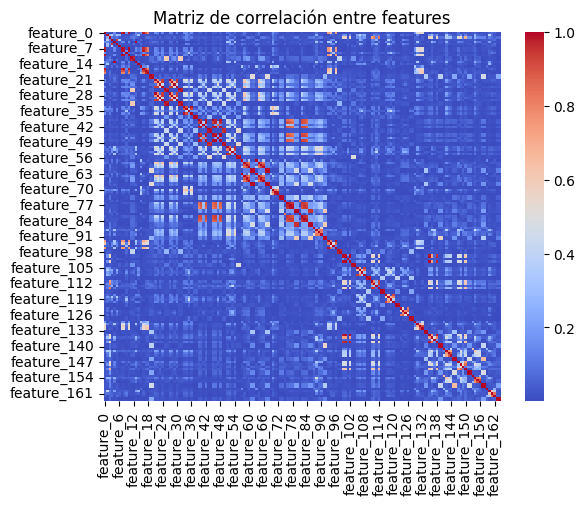

In [20]:
import seaborn as sns
corr_matrix = df[features].corr().abs()
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0)
plt.title("Matriz de correlación entre features")
plt.show()


### Reducción de dimensionalidad

Para estudiar la estructura de los datos, realizaremos un análisis de reducción de dimensionalidad que nos permita visualizar los datos en dos dimensiones. 

In [21]:
from sklearn.preprocessing import StandardScaler

# escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


In [22]:
# removemos outliers (5 desviaciones estandar, poco estricto)
z_scores = np.abs((X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0))
mask = (z_scores < 5).all(axis=1)
X_clean = X_scaled[mask]
df_clean = df.loc[mask]


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

df_clean['pca_1'] = X_pca[:, 0]
df_clean['pca_2'] = X_pca[:, 1]


/tmp/ipykernel_300/2860099559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pca_1'] = X_pca[:, 0]
/tmp/ipykernel_300/2860099559.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pca_2'] = X_pca[:, 1]


In [24]:
df_clean.shape, df.shape

((200857, 170), (234355, 168))

/tmp/ipykernel_300/1090401354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['fraud_label_str'] = df_clean['fraud_label'].map({


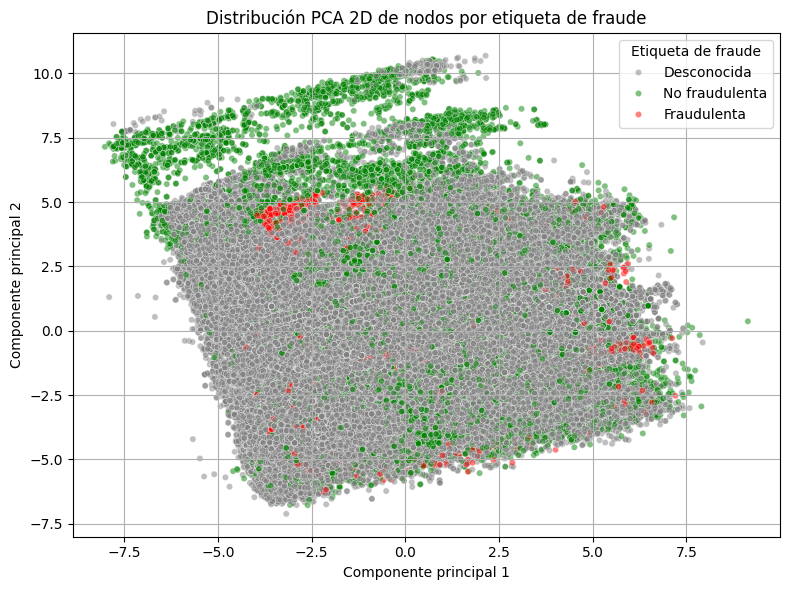

In [25]:

# Mapeo para etiquetas legibles
df_clean['fraud_label_str'] = df_clean['fraud_label'].map({
    1: 'Fraudulenta',
    0: 'No fraudulenta',
    2: 'Desconocida'
})

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_clean,
    x='pca_1',
    y='pca_2',
    hue='fraud_label_str',
    palette={'Fraudulenta': 'red', 'No fraudulenta': 'green', 'Desconocida': 'gray'},
    alpha=0.5,
    s=20
)

plt.title("Distribución PCA 2D de nodos por etiqueta de fraude")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Etiqueta de fraude")
plt.grid(True)
plt.tight_layout()
plt.show()


Vemos que las transacciones etiquetadas como fraudulentas tienden a agruparse. Esto sugiere que las 2 componentes principales contienen patrones útiles para detectar fraude. 

Concluimos que la estructura de los datos es adecuada para entrenar un modelo de clasificación supervisado. 

## Referencias


1. M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

2. Elliptic, www.elliptic.co.

